In [1]:
import pandas as pd
import json
from collections import defaultdict
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import datetime
%load_ext tensorboard

In [6]:
def split_dataset(dataset_len, test_split=0.3):
    
    test = int(round(dataset_len*test_split, 0))
    if test < 1:
        raise("Test split has 0 samples")
    else:
        split = ["test"] * test
        train = int(round(dataset_len*(1-test_split), 0))
        split.extend(["train"] * train)
        random.shuffle(split)
    return split

def generate_metadata(image_dir:str,labels_path:str,output_dir:str) -> pd.DataFrame:
    
    with open(labels_path) as f:
        data = json.load(f)
    
    _metadata = defaultdict(list)
        
    for key,value in data['_via_img_metadata'].items():
        filepath = os.path.join(IMAGE_DIR,value['filename'])
        img = Image.open(filepath)
        width, height = img.size[0], img.size[1]
        
        _metadata['filename'].append(value['filename'])
        _metadata['filepath'].append(filepath)

        _metadata['TL_x'].append(value['regions'][0]['shape_attributes']['cx'])
        _metadata['TL_y'].append(value['regions'][0]['shape_attributes']['cy'])

        _metadata['TR_x'].append(value['regions'][1]['shape_attributes']['cx'])
        _metadata['TR_y'].append(value['regions'][1]['shape_attributes']['cy'])

        _metadata['BL_x'].append(value['regions'][2]['shape_attributes']['cx'])
        _metadata['BL_y'].append(value['regions'][2]['shape_attributes']['cy'])

        _metadata['BR_x'].append(value['regions'][3]['shape_attributes']['cx'])
        _metadata['BR_y'].append(value['regions'][3]['shape_attributes']['cy'])
        
        
        _metadata['TL_x_rel'].append(value['regions'][0]['shape_attributes']['cx']/width)
        _metadata['TL_y_rel'].append(value['regions'][0]['shape_attributes']['cy']/height)

        _metadata['TR_x_rel'].append(value['regions'][1]['shape_attributes']['cx']/width)
        _metadata['TR_y_rel'].append(value['regions'][1]['shape_attributes']['cy']/height)

        _metadata['BL_x_rel'].append(value['regions'][2]['shape_attributes']['cx']/width)
        _metadata['BL_y_rel'].append(value['regions'][2]['shape_attributes']['cy']/height)

        _metadata['BR_x_rel'].append(value['regions'][3]['shape_attributes']['cx']/width)
        _metadata['BR_y_rel'].append(value['regions'][3]['shape_attributes']['cy']/height)
        
    
    metadata = pd.DataFrame(_metadata)
    metadata['split'] = split_dataset(len(metadata), test_split=0.10)
    metadata.to_csv(os.path.join(METADATA_OUTPUT_DIR,'metadata.csv'),index=False)
    
    return metadata

def build_sources_from_metadata(metadata, data_dir, mode='train'):
    """
    ...
    """
    df = metadata.copy()
    df = df[df['split'] == mode]
    df['filepath'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    sources = list(zip(df['filepath'],zip(
                       df['TL_x_rel'],
                       df['TL_y_rel'],
                       df['TR_x_rel'],
                       df['TR_y_rel'],
                       df['BL_x_rel'],
                       df['BL_y_rel'],
                       df['BR_x_rel'],
                       df['BR_y_rel'])
                      ))
    return sources

def preprocess_data(image, pixels):
    image = tf.image.resize(image, size=(pixels, pixels))
    image = image / 255.0
    return image 

def augment_image(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    return image


def make_dataset(sources, training=False, batch_size=1, num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None, pixels = 240, target = 1):
    
    def load(row):
        filepath = row['image']
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
        return img, row['label']
    
    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size * 4
    
    images, label = zip(*sources)
    
    ds = tf.data.Dataset.from_tensor_slices({
        'image': list(images), 'label': list(label)}) 
    
    if training:
        ds = ds.shuffle(shuffle_buffer_size)
        
    
    ds = ds.map(load , num_parallel_calls=num_parallel_calls)
    ds = ds.map(lambda x,y: (preprocess_data(x,pixels), y))
    ds = ds.map(lambda x,y: (augment_image(x), y))

    ds = ds.repeat(count=num_epochs)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = 1)
    
    return ds

def imshow_batch_of_twenty(batch):
    label_batch = batch[1].numpy()
    image_batch = batch[0].numpy()
    fig, axarr = plt.subplots(4, 5, figsize=(20, 20), sharey=True)
    cont = 0
    for i in range(4):
        for j in range (5):
            img = image_batch[cont, ...]
            axarr[i,j].imshow(img)
            axarr[i,j].set(xlabel='Image {} '.format(cont+1))
            axarr[i,j].plot(label_batch[cont][0]*img.shape[0] ,label_batch[cont][1]*img.shape[1],'ro',markersize=10)
            axarr[i,j].plot(label_batch[cont][2]*img.shape[0] ,label_batch[cont][3]*img.shape[1],'ro',markersize=10)
            axarr[i,j].plot(label_batch[cont][4]*img.shape[0] ,label_batch[cont][5]*img.shape[1],'ro',markersize=10)
            axarr[i,j].plot(label_batch[cont][6]*img.shape[0] ,label_batch[cont][7]*img.shape[1],'ro',markersize=10)
            cont +=1

def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)


In [12]:
model_path = "../models/cd_transfer_learning"
img = "../data/images_test/02.jpg"
model = tf.saved_model.load(model_path)

In [13]:
img = tf.io.read_file(img)
img = tf.io.decode_jpeg(img)
input_tensor = preprocess_data(img, 224)
preds = model(input_tensor[tf.newaxis, ...]).numpy()[0]

In [14]:
preds

array([0.2707177 , 0.0437017 , 0.94295216, 0.17293891, 0.04551708,
       0.63154465, 0.47710034, 0.97560877], dtype=float32)

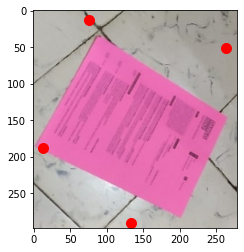

In [16]:
plt.imshow(img)
plt.plot(preds[0]*img.shape[1],preds[1]*img.shape[0],'ro',markersize=10)
plt.plot(preds[2]*img.shape[1],preds[3]*img.shape[0],'ro',markersize=10)
plt.plot(preds[4]*img.shape[1],preds[5]*img.shape[0],'ro',markersize=10)
plt.plot(preds[6]*img.shape[1],preds[7]*img.shape[0],'ro',markersize=10)